# Statistical Techniques for Data Science and Robotics Assignment 1
## Tishkin Pavel

In [1]:
import numpy as np
import random
import math
import time
import sys
from matplotlib import pyplot as plt

### Implementation of ARS97 algorithm

This algorithm was implemented based on articles:

- https://ieeexplore.ieee.org/document/9001104
- https://www.researchgate.net/publication/2301429_A_One-Pass_Algorithm_for_Accurately_Estimating_Quantiles_for_Disk-Resident_Data

In [2]:
class ARS97:
    def __init__(self, data: np.array, m: int, s: int):
        """
        m: Int. Size of a run. Number of runs is n/m
        s: Int. Number of samples to derive from a run. Should be of power 2.
        """
        self.data = data
        self.m = m
        self.s = s
        self.n = len(data)
        self.r = self.n/self.m
        self.max_depth = int(math.log(s, 2))
        self.samples = np.array([])
    
    def sample(self, data: np.array):
        """
        Finds samples for the given run of the dataset
        
        data: np.array. Run for which to find samples
        """
        lists = self.divide(data, 0)
        samples = np.array([max(l) for l in lists])
        return samples
        
    def divide(self, data: np.array, depth: int):
        """
        Helper function which recursively divides original data to sub arrays
        until reaches the nesessary size as stated in paper
        
        data: np.array. Data to be divided
        depth: Int. current depth of division
        """
        if depth == self.max_depth:
            return np.array([data])
        else:
            median = np.median(data)
            half = len(data) // 2
            left = np.array(list(filter(lambda x: x < median, data)))
            left = self.impute(left, median, half)
            right = np.array(list(filter(lambda x: x > median, data)))
            right = self.impute(right, median, half)
            return np.append(self.divide(left, depth+1), self.divide(right, depth+1), axis=0)
    
    def impute(self, data: np.array, median: float, half: int):
        """
        Imputes the data with median value to have lists of equal length
        (If we have the median as a repeated value this comes handy)
        
        data: np.array. Original array
        median: float. Median value
        half: int. Size of the half array, which our array should be equal to in size
        """
        length = half - len(data)
        if (length > 0):
            return np.append(data, np.full(length, median))
        else:
            return data
    
    def sample_phase(self):
        """
        Sample Phase of the original paper
        """
        m = self.m
        for i in range(len(self.data)//m):
            samples = self.sample(self.data[i*m:(i+1)*m])
            self.samples = np.append(self.samples, self.sample(self.data[i*m:(i+1)*m]), axis=0)
        self.samples = sorted(self.samples)
        
    def quantile_phase(self, quantile: float):
        """
        Quantile Phase of the original paper
        Returns lower bound and upper bound of estimation
        
        quantile: Float: quantile to be approximated
        """
        sm = self.s/self.m
        alpha = self.n*quantile
        lower = math.ceil((sm)*alpha - (self.r-1)*(1-sm))
        upper = math.floor(alpha*(sm))
        return self.samples[lower], self.samples[upper] 

### Method simulation

In [3]:
data = np.array(np.linspace(1, 1024, 1024))
actual = data[int(1024*0.5)]
np.random.shuffle(data)

In [4]:
ars = ARS97(data, 128, 64)
ars.sample_phase()
lower, upper = ars.quantile_phase(0.5)
print(f'Lower bound of Quantile: {lower}')
print(f'Upper bound of Quantile: {upper}')
print(f'Actual quantile: {actual}')
print(f'Actual quantile is in the range [{lower}-{upper}],')
print(f'and satisfies the guarantee of the algorithm of max range {upper-lower} <= {ars.n/ars.s}')

Lower bound of Quantile: 511.0
Upper bound of Quantile: 518.0
Actual quantile: 513.0
Actual quantile is in the range [511.0-518.0],
and satisfies the guarantee of the algorithm of max range 7.0 <= 16.0


### Complexity analysis

### Time Complexity

In [5]:
data = [np.array(np.linspace(1, 2**i, 2**i)) for i in range(10, 18, 2)]
times = []
spaces = []
for d in data:
    start_time = time.time()
    ars = ARS97(d, 128, 64)
    ars.sample_phase()
    ars.quantile_phase(0.5)
    spaces.append(sys.getsizeof(ars.samples))
    times.append(time.time() - start_time)

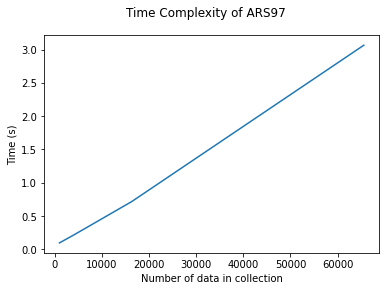

In [6]:
plt.plot([2**i for i in range(10, 18, 2)], times)
plt.suptitle('Time Complexity of ARS97')
plt.xlabel("Number of data in collection")
plt.ylabel('Time (s)')
plt.show()

As we can see, the graph shows linear complexity, which is exactly as was stated in the original paper

### Space Complexity

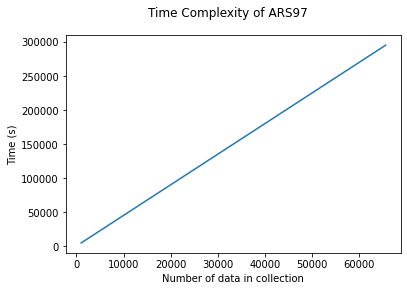

In [7]:
plt.plot([2**i for i in range(10, 18, 2)], spaces)
plt.suptitle('Time Complexity of ARS97')
plt.xlabel("Number of data in collection")
plt.ylabel('Time (s)')
plt.show()

Space Complexity of this algorithm is $$O(m + \frac{n}{m} * s) = O(n)$$ where m - size of the run and r - number of runs. The equality holds due to m and s being constants and n is the only parameter that is dependent on data. In my analysis I measured only the size of samples due to it being the only non-constant thing in the equation and it is indeed linear. The original paper speaks nothing of space complexity